---
# <font color=blue>Let's Build An Automated Anomalous DB Activity Detector<br>Using Machine Learning
</font>

## Demonstration For My East Coast Oracle (ECO) Conference Presentation On November 2, 2020

FREE Machine Learning E-Course For Oracle Professionals
https://www.orapub.com/ml-ecourse

Author: Craig Shallahamer, craig@orapub.com
<br>Latest: 30-Oct-2020 v2n

The Process And Objective

* The objective of this project is to build unsupervised single cluster machine learning model to detect an anomalous Oracle performance situation that warrent an analyst's attention... before the phone starts ringing!
* Build a k-means one cluster unsupervised model based on all available AWR dba_hist_sysmetric_summary data
* Determine the anomaly distance threshold in multi-dimensional space
* Check if most recent AWR snap distance exceed the threshold, thereby being an anomoly
* If so create chart and alert

Key Topics

* Multi-dimensional space
* K-means clusters
* Distance to centroid in a multi-dimensional space
* How to determine an anomaly threshold
* Center and scale data
* Dimensional reduction
* Denomalizing normalized data using Python
* Charting and saving output to file
* General Python functions and testing


In [6]:
testing = True
print(testing)

True


In [7]:
print("Loading libraries", end=" ")

import numpy as np   # To do array and math stuff
import pandas as pd  # To do dataframe and math stuff
import matplotlib    # To do plots
import os            # To access your local OS
import sklearn       # The core ML algorithms
import pickle        # file IO
    
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn import preprocessing        
from collections import Counter
from numpy import unique

print("done.")

Loading libraries done.


In [8]:
# Core Settings

print("Making core settings")
    
#pd.set_option('display.max_row', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)
np.set_printoptions(precision=3)
low_memory=False
    
baseURL = "http://"  # This should always work
    
os.chdir("/Users/anathale/Desktop/AIML/AWRAnalysis/testing")       # <------ !!! IMPORTANT !!! SET APPROPRIATELY

print("   ", baseURL)
print("   ", os.getcwd())
print("\n    IMPORTANT: Make sure these directories exist:")
print("               " + str(os.getcwd()) + "/pypics/kmeans")
print("               " + str(os.getcwd()) + "/pypics/MiniBatchKMeans")

print("\nDone.")


Making core settings
    http://
    /Users/anathale/Desktop/AIML/AWRAnalysis/testing

    IMPORTANT: Make sure these directories exist:
               /Users/anathale/Desktop/AIML/AWRAnalysis/testing/pypics/kmeans
               /Users/anathale/Desktop/AIML/AWRAnalysis/testing/pypics/MiniBatchKMeans

Done.


In [9]:
# Load lead data, Read the CSV file into dataframe, leadsDF

def loadData(csvFN_in, verbose_in):
    
    if verbose_in:
        print("Loading data")
        print("   "+ str(csvFN_in))
    
    try:
        print("   Loading data from local machine", end="...")
        dataDF = pd.read_csv(csvFN_in)
        print("done.")
    except:
        print("not found.")
        print("   Retreiving from base URL", end="...")
        URLFN  = baseURL + csvFN_in
        dataDF = pd.read_csv(URLFN)
        print("done.")
        print("   Saving file on local macine", end="...")
        dataDF.to_csv (csvFN_in, index=None, header=True)
        print("done.")
        
    print("   Shape", dataDF.shape)

    return(dataDF)

if testing:
    print("Testing Function: loadData")
    testDF = loadData("dmwperfenv.csv",True)
    print()
    print(testDF.shape)
    print(testDF.head(4))

print("\nDone.")


Testing Function: loadData
Loading data
   dmwperfenv.csv
   Loading data from local machine...done.
   Shape (88006, 16)

(88006, 16)
   SNAP_ID       DBID  INSTANCE_NUMBER     BEGIN_TIME       END_TIME  INTSIZE  \
0     5074  882962339                1  7/10/20 12:59  7/10/20 13:59   360013   
1     5042  882962339                1    7/9/20 4:59    7/9/20 5:59   359937   
2     5026  882962339                1   7/8/20 12:59   7/8/20 13:59   360004   
3     5006  882962339                1   7/7/20 18:59   7/7/20 19:59   360039   

   GROUP_ID  METRIC_ID             METRIC_NAME                    METRIC_UNIT  \
0         2       2000  Buffer Cache Hit Ratio  % (LogRead - PhyRead)/LogRead   
1         2       2000  Buffer Cache Hit Ratio  % (LogRead - PhyRead)/LogRead   
2         2       2000  Buffer Cache Hit Ratio  % (LogRead - PhyRead)/LogRead   
3         2       2000  Buffer Cache Hit Ratio  % (LogRead - PhyRead)/LogRead   

   NUM_INTERVAL  MINVAL      MAXVAL    AVERAGE  STAND

In [10]:
# Cleanup the features

def cleanupFeatures(df_in, features_in, verbose_in):
    
    if verbose_in:
        print("Cleaning features", df_in.shape)
    
    for featureName in features_in:
        df_in[featureName] = [x.replace(" ", "") for x in df_in[featureName]]
        df_in[featureName] = [x.replace("'", "") for x in df_in[featureName]]
        #df_in[featureName] = df_in[featureName].str.lower()
    
    if verbose_in:
        print("done.")
        
    return(df_in)

if testing:
    print("Testing Function: cleanupFeatures")
    print("\n    Before (METRIC_NAME)")
    print(testDF['METRIC_NAME'].head(4))
    print()
    testDF = cleanupFeatures(testDF.copy(), ['METRIC_NAME'], True)
    print("\n    After (METRIC_NAME)")
    print(testDF['METRIC_NAME'].head(4))
    
print("\nDone.")


Testing Function: cleanupFeatures

    Before (METRIC_NAME)
0    Buffer Cache Hit Ratio
1    Buffer Cache Hit Ratio
2    Buffer Cache Hit Ratio
3    Buffer Cache Hit Ratio
Name: METRIC_NAME, dtype: object

Cleaning features (88006, 16)
done.

    After (METRIC_NAME)
0    BufferCacheHitRatio
1    BufferCacheHitRatio
2    BufferCacheHitRatio
3    BufferCacheHitRatio
Name: METRIC_NAME, dtype: object

Done.


In [11]:
# Load and Cleanup Snapshot Data

def loadAndCleanSnapshot(csvLoc_in, verbose_in):

    if verbose_in:
        print("LoadAndCleanSnapshot")
        print("   " + str(csvLoc_in))
    
    mySnapDF = loadData(csvLoc_in,True)
    
    if verbose_in:
        print("   BEGIN mySnapDF columns:", mySnapDF.columns.tolist())
    
    # Don't need to use standard cleanupFeatures function
    #mySnapDF = cleanupFeatures(mySnapDF, [mySnapDF.columns], True)
    
    # Adding new date/time features for easier date display
    #snapDF['snap_dur_sec'] = (snapDF['end_interval_time'].astype('datetime64[ns]')-snapDF['begin_interval_time'].astype('datetime64[ns]'))/ timedelta(seconds=1)
    mySnapDF['beg_time']     = mySnapDF['BEGIN_INTERVAL_TIME']
    mySnapDF['end_time']     = mySnapDF['END_INTERVAL_TIME']
    mySnapDF['snap_id']      = mySnapDF['SNAP_ID']

    features = ['snap_id','beg_time','end_time']
    mySnapDF   = mySnapDF[features]
    
    if verbose_in:
        print()
        print("   AFTER mySnapDF columns:", mySnapDF.columns.tolist())
        print("done.")
    
    return(mySnapDF)


if testing:
    snapDF = loadAndCleanSnapshot("dmwprefenvsnpdet.csv",True)

print("\nDone.")


LoadAndCleanSnapshot
   dmwprefenvsnpdet.csv
Loading data
   dmwprefenvsnpdet.csv
   Loading data from local machine...done.
   Shape (1506, 11)
   BEGIN mySnapDF columns: ['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'STARTUP_TIME', 'BEGIN_INTERVAL_TIME', 'END_INTERVAL_TIME', 'FLUSH_ELAPSED', 'SNAP_LEVEL', 'ERROR_COUNT', 'SNAP_FLAG', 'SNAP_TIMEZONE']

   AFTER mySnapDF columns: ['snap_id', 'beg_time', 'end_time']
done.

Done.


In [12]:
# Denormalize. Focused on dba_hist_sysmetric_summary data

def denormalize(df_in,verbose_in):
    
    if verbose_in:
        print("Denormalizing")
        print("   BEFORE ", df_in.shape)
        
    df_inPiv = df_in.pivot_table(index='SNAP_ID', values='AVERAGE', columns=['METRIC_NAME'])
    df_inPiv.reset_index(inplace=True)

    if verbose_in:
        print("   AFTER  ", df_inPiv.shape)
        print("done.")

    return(df_inPiv)
    
    
if testing:
    print("Testing Function: denormalize")
    features = ['SNAP_ID','METRIC_NAME','AVERAGE']
    testDF = testDF[features]
    testDFpiv = denormalize(testDF, True)
    print()
    print(testDFpiv[['SNAP_ID','AverageActiveSessions', 'CPUUsagePerSec','MemorySortsRatio']].head())

print("\nDone.")


Testing Function: denormalize
Denormalizing
   BEFORE  (88006, 3)
   AFTER   (280, 159)
done.

METRIC_NAME  SNAP_ID  AverageActiveSessions  CPUUsagePerSec  MemorySortsRatio
0               4902               0.083737        6.787013         99.997501
1               4903               0.069534        6.485955        100.000000
2               4904               0.077124        6.815617        100.000000
3               4905               0.069264        6.431147        100.000000
4               4906               0.069193        6.469146        100.000000

Done.


In [13]:
# denormalizeWaitStats. Focused on dba_hist_WAITSTATS data

def denormalizeWaitStats(df_in,verbose_in):
    
    if verbose_in:
        print("Denormalizing")
        print("   BEFORE ", df_in.shape)
        
    df_inPiv = df_in.pivot_table(index='SNAP_ID', values='WAIT_COUNT', columns=['CLASS'])
    df_inPiv.reset_index(inplace=True)

    if verbose_in:
        print("   AFTER  ", df_inPiv.shape)
        print("done.")

    return(df_inPiv)
    
    
if testing:
    print("Testing Function: loadData")
    testDF1 = loadData("dmeperfenv_waitevent.csv",True)

    print("Testing Function: denormalize")
    features = ['SNAP_ID','CLASS','WAIT_COUNT']
    testDF1 = testDF1[features]
    testDFpiv1 = denormalizeWaitStats(testDF1, True)
    print()
    print(testDFpiv1[['SNAP_ID','save undo block', 'data block','unused']].head())
    #print(testDFpiv.columns)

print("\nDone.")


Testing Function: loadData
Loading data
   dmeperfenv_waitevent.csv
   Loading data from local machine...done.
   Shape (25848, 6)
Testing Function: denormalize
Denormalizing
   BEFORE  (25848, 3)
   AFTER   (718, 19)
done.

CLASS  SNAP_ID  save undo block  data block  unused
0         4937              0.0     23487.5     0.0
1         4938              0.0     23618.5     0.0
2         4939              0.0     23804.0     0.0
3         4940              0.0     23950.5     0.0
4         4941              0.0     57745.0     0.0

Done.


In [14]:
# Function: Dimension Reduction Using Either:
#           PCA: Principle Component Analysis
#           ICA: Independent Component Analysis

def DimReduce(df_in, model_in, dimensions_in, verbose_in):
    
    if verbose_in:
        print("Reducing dimensionality")
    
    in_shape = df_in.shape
    
    if model_in == 'PCA':
        
        from sklearn.decomposition import PCA                 # load library
        pca       = PCA(n_components=dimensions_in)           # init model
        array_out = pca.fit_transform(df_in)                  # fit DF_in and transform DF_in
        
    elif model_in == 'ICA':
        
        from sklearn.decomposition import FastICA                        # load library
        ICA       = FastICA(n_components=dimensions_in, random_state=12) # init model
        array_out = ICA.fit_transform(df_in)                             # fit DF_in and transform DF_in
        
    else:
        print("   ERROR Function DimReduce. Invalid model provide.")
    
    df_out = pd.DataFrame(data = array_out) # create DF from array
    
    if verbose_in:
        print("   From/to", df_in.shape, df_out.shape)
        
    return(df_out, array_out)

if testing:
    print("Testing Function: DimRed2")
    print("     BEFORE", testDF.shape)
    qaDF, bogus = DimReduce(testDFpiv.drop(columns=['SNAP_ID']), 'PCA', 3, True)
    print("     AFTER ", qaDF.shape)
    print()
    print(qaDF.head(4))

print("\nDone.")


Testing Function: DimRed2
     BEFORE (88006, 3)
Reducing dimensionality
   From/to (280, 158) (280, 3)
     AFTER  (280, 3)

              0             1             2
0 -4.510193e+09  1.657342e+09  2.553002e+07
1 -4.605250e+09  1.658850e+09  2.489804e+07
2 -4.601535e+09  1.654584e+09  3.982954e+07
3 -4.605258e+09  1.661445e+09  2.505973e+07

Done.


In [15]:
# Function: Standardize: Center (mean=0) and Scale (stdev=1):
#           1. fit Standardize model with the given dataframe
#           2. transforms the given dataframe
#           4. returns the transformed data as Dataframe

def CS_encode(df_in, verbose_in):
    
    if verbose_in:
        print("Standardizing", end=" ")
    
    from sklearn.preprocessing import StandardScaler   # load lib
    scaler = preprocessing.StandardScaler().fit(df_in) # init and fit model 
    ARcs = scaler.transform(df_in)                     # scale/transform inDF, result an array
    DFcs = pd.DataFrame(ARcs, columns=df_in.columns)   # convert result array to DF
    
    if verbose_in:
        print("done.")
        
    return(DFcs)                                       # return the c&s DF


if testing:
    print("Testing Function: CS_encode\n")
    print(testDFpiv[['AverageActiveSessions','CPUUsagePerSec']].describe())
    print()

    qaDF = CS_encode(testDFpiv.drop(columns=['SNAP_ID']), True)
    
    print()
    print(qaDF[['AverageActiveSessions','CPUUsagePerSec']].describe())
    
print("\nDone.")


Testing Function: CS_encode

METRIC_NAME  AverageActiveSessions  CPUUsagePerSec
count                   280.000000      280.000000
mean                     12.306705      321.242847
std                      42.866774      661.166128
min                       0.002932        0.306437
25%                       0.110068        8.995016
50%                       1.078019       68.091407
75%                       4.535926      310.611356
max                     407.750755     4102.342859

Standardizing done.

METRIC_NAME  AverageActiveSessions  CPUUsagePerSec
count                 2.800000e+02    2.800000e+02
mean                 -2.061843e-17    2.307678e-16
std                   1.001791e+00    1.001791e+00
min                  -2.875374e-01   -4.862788e-01
25%                  -2.850337e-01   -4.731139e-01
50%                  -2.624128e-01   -3.835718e-01
75%                  -1.816020e-01   -1.610870e-02
max                   9.241472e+00    5.729075e+00

Done.


In [16]:
# Function: From a dataframe, create cluster,
# returning the model def, fitted model and fitted predict model

def create_cluster(df_in, cluster_type_in, cluster_no_in, verbose_in):
    
    if verbose_in:
        print("Creating cluster " + str(cluster_type_in) + " " + str(cluster_no_in), end=" ")
    
    if cluster_type_in == 'kmeans':
        
        from sklearn.cluster import KMeans
        mymodel          = KMeans(n_clusters=cluster_no_in, init='k-means++', max_iter=300, n_init=10, random_state=0)
        mymodelfit       = mymodel.fit(df_in)
        mymodelfitlabels = mymodelfit.labels_
        mymodelfitpred   = mymodelfit.predict(df_in)
        
    elif cluster_type_in == 'MiniBatchKMeans':
        
        from sklearn.cluster import MiniBatchKMeans
        mymodel          = MiniBatchKMeans(n_clusters=cluster_no_in, batch_size=100, init='k-means++', max_iter=300, n_init=10, random_state=0)
        mymodelfit       = mymodel.fit(df_in)
        mymodelfitlabels = mymodelfit.labels_
        mymodelfitpred   = mymodelfit.predict(df_in)

    else:
        print("   ERROR in function, create_cluster")
        
    if verbose_in:
        print("done.")
    
    return(mymodel, mymodelfit, mymodelfitpred)


if testing:
    
    print("Testing Function: create_cluster")

    modelList = ['kmeans','MiniBatchKMeans']
    
    for myclustertype in modelList:
          
        print()
        print(myclustertype + str("......................................."))
        myclusterno   = 1
        qaDF = CS_encode(testDFpiv.drop(columns=['SNAP_ID']), True)
        myModel, myModelFit, myModelFitPred = create_cluster(qaDF, myclustertype, myclusterno, True)
        print("")
        print("   Cluster type        :", myclustertype)
        print("   Cluster numbers     :", myclusterno)
        print("   Cluster points      :", len(myModelFitPred))
        #print("   Counter Fit Labels  :", Counter(myModelFit.labels_))
        print("   Counter Fit U Labels:", unique(myModelFitPred))
        print("   Cluster model       :", myModel)

print("\nDone.")


Testing Function: create_cluster

kmeans.......................................
Standardizing done.
Creating cluster kmeans 1 done.

   Cluster type        : kmeans
   Cluster numbers     : 1
   Cluster points      : 280
   Counter Fit U Labels: [0]
   Cluster model       : KMeans(n_clusters=1, random_state=0)

MiniBatchKMeans.......................................
Standardizing done.
Creating cluster MiniBatchKMeans 1 done.

   Cluster type        : MiniBatchKMeans
   Cluster numbers     : 1
   Cluster points      : 280
   Counter Fit U Labels: [0]
   Cluster model       : MiniBatchKMeans(max_iter=300, n_clusters=1, n_init=10, random_state=0)

Done.


In [17]:
# Function: Calculate distances between the a given cluster center and
#           every point in the given Dataframe.
#           AND, determine the anomaly threshold value

def get_point_to_centroid(cluster_type_in, cluster_init_in, cluster_fit_in, points_DF_in, cluster_no_in, verbose_in):
    
    if verbose_in:
        print("Get_point_to_centroid")
    
    from numpy import linalg as LA
    
    mypoints = points_DF_in.to_numpy()
    distances=[]
    i = 0
    for datapoint in mypoints:
        #print(datapoint)        
        distances.append( LA.norm(datapoint-cluster_init_in.cluster_centers_[cluster_no_in]) )        
        
        i = i +1
    
    points_DF_out              = points_DF_in
    points_DF_out['distance']  = distances
    
    threshold                  = np.quantile(distances, 0.98)  # super simple threshold determination strategy
    
    points_DF_out['threshold'] = threshold
    
    if verbose_in:
        # Calculate statistics, choose and set threshold value
        print("      mean=%0.2f median=%0.2f" % ( np.mean(distances), np.median(distances) ))
        print("      95-pct=%0.2f 98-pct=%0.2f" % ( np.quantile(distances, 0.95), np.quantile(distances, 0.98) ))
        print("      min=%0.2f max=%0.2f" % ( np.min(distances), np.max(distances) ))
        print("      points, threshold", len(distances), threshold)
    
    if verbose_in:
        print("done.")
        
    return(points_DF_out, threshold)
    

if testing:
    print("Testing Function: get_point_to_centroid")
    
    modelList = ['kmeans','MiniBatchKMeans']
    
    for myclustertype in modelList:
    
        print("\n" + myclustertype + str(".......................................\n"))
        myclusters    = 1 # number of clusters created
        myclusterNo   = 0 # cluster number to get point centroid details, starting with 0
        qaDF, bogus = DimReduce(testDFpiv.drop(columns=['SNAP_ID']), 'PCA', 3, True)
        qaDF = CS_encode(qaDF, True)
        myModel, myModelFit, myCluster = create_cluster(qaDF, myclustertype, myclusters, True)
        print()
        print("      Cluster type   :", myclustertype)
        print("      Cluster numbers:", myclusters)
        print("      Cluster points :", len(myCluster))
        print("      Cluster model  :", myModel)
        print("details:",myModelFit)
        mypointsDF, threshold = get_point_to_centroid(myclustertype, myModel, myCluster, qaDF, myclusterNo, True)
        print("      points, threshold",len(mypointsDF), threshold)
        print(mypointsDF.head(4))

    print("\nDone Testing Function: get_point_to_centroid")

print("\nDone.")


Testing Function: get_point_to_centroid

kmeans.......................................

Reducing dimensionality
   From/to (280, 158) (280, 3)
Standardizing done.
Creating cluster kmeans 1 done.

      Cluster type   : kmeans
      Cluster numbers: 1
      Cluster points : 280
      Cluster model  : KMeans(n_clusters=1, random_state=0)
details: KMeans(n_clusters=1, random_state=0)
Get_point_to_centroid
      mean=1.43 median=1.16
      95-pct=3.37 98-pct=4.61
      min=0.07 max=7.30
      points, threshold 280 4.608793798454718
done.
      points, threshold 280 4.608793798454718
          0         1         2  distance  threshold
0 -0.472917  2.060596  0.093398  2.116230   4.608794
1 -0.482884  2.062471  0.091086  2.120203   4.608794
2 -0.482495  2.057167  0.145710  2.118010   4.608794
3 -0.482885  2.065697  0.091677  2.123367   4.608794

MiniBatchKMeans.......................................

Reducing dimensionality
   From/to (280, 158) (280, 3)
Standardizing done.
Creating cluster 

In [18]:
# Function: Return the begin and time times for a given snap_id

def get_b_e_times(snapDF_in, snap_id_in):
    
    b_time      = (snapDF_in['beg_time'].loc[snapDF_in['snap_id'] == snap_id_in]).squeeze()
    e_time      = (snapDF_in['end_time'].loc[snapDF_in['snap_id'] == snap_id_in]).squeeze()
    
    return(b_time, e_time)

if testing:
    print("Testing Function: get_b_e_times")
    print(snapDF.shape)
    print(snapDF.head(2))
    
    print()
    print("    First snap_id  ", snapDF['snap_id'][0])
    print("    First begin/end", get_b_e_times(snapDF, snapDF['snap_id'][0]))
    print("\nDone Testing function: get_b_e_times")

print("\nDone.")


Testing Function: get_b_e_times
(1506, 3)
   snap_id                         beg_time                         end_time
0     4978  06-JUL-20 03.00.01.316000000 PM  06-JUL-20 04.00.04.657000000 PM
1     4984  06-JUL-20 09.00.13.132000000 PM  06-JUL-20 10.00.25.137000000 PM

    First snap_id   4978
    First begin/end (0       06-JUL-20 03.00.01.316000000 PM
1011    06-JUL-20 03.00.01.351000000 PM
Name: beg_time, dtype: object, 0       06-JUL-20 04.00.04.657000000 PM
1011    06-JUL-20 04.00.04.694000000 PM
Name: end_time, dtype: object)

Done Testing function: get_b_e_times

Done.


Testing Function: chart_anom
---------- Cluster type  kmeans
Standardizing done.
Creating cluster kmeans 1 done.


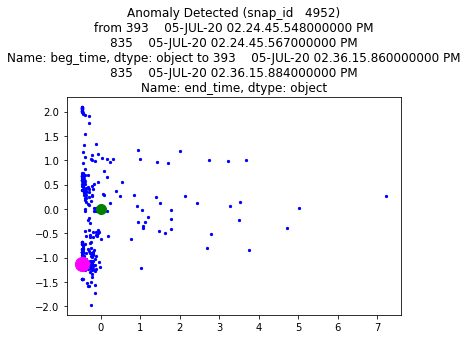

---------- Cluster type  MiniBatchKMeans
Standardizing done.
Creating cluster MiniBatchKMeans 1 done.


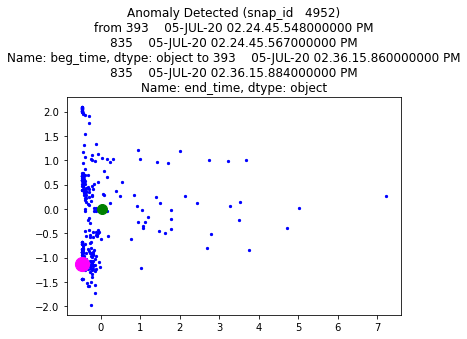

Done Testing Function: chart_anom

Done.


In [19]:
# Function: Print anomalous chart (screen and disk)
#           Assumption is an anomalous situation has been detected

def chart_anom2D(featuresDF_in, snapDF_in, snap_id_in, cluster_type_in, CS_in):
    
    # To plot a 2D chart, must reduce dimensnions from N to 2.
    featuresDF, features = DimReduce(featuresDF_in.drop(columns=['SNAP_ID']), 'PCA', 2, False)
    
    if CS_in:
        featuresDF = CS_encode(featuresDF, True)
        features   = featuresDF.to_numpy()
    
    # Create a 1 cluster model
    myclustertype = cluster_type_in
    myclusters    = 1 # number of clusters created
    myclusterNo   = 0 # cluster number to get point centroid details, starting with 0
    myModel, myModelFit, myCluster = create_cluster(featuresDF, myclustertype, myclusters, True)
    
    # Plot all points, including the current snap_id point
    plt.scatter(features[:,0], features[:,1], s=5, c='blue')      # using array
    #plt.scatter(featuresDF.C1, featuresDF.C2, s=5, c='blue')   # using DF, if columns C1 and C2
    
    # Plot the cluster center(s), only 1 for LVC
    plt.scatter(myModel.cluster_centers_[:, 0], myModel.cluster_centers_[:, 1], s=100, c='green')
    
    # Plot the most recent point/snap
    rowidx = len(featuresDF.index)-1
    #print("rowidx",rowidx)
    plt.scatter(features[rowidx,0], features[rowidx,1], s=200, c='magenta')
    
    # Set the title
    b_time, e_time = get_b_e_times(snapDF_in, snap_id_in)
    mytitle1 = "Anomaly Detected (snap_id {s:6d})\n".format(s=snap_id_in)
    mytitle2 = "from {beg} to {end}".format(beg=b_time, end=e_time)
    plt.title(mytitle1+mytitle2)
    
    # Save chart to disk in the existing sub directories
    filename2 = 'pypics/' + str(cluster_type_in) + '/' + str(snap_id_in) + '.png'
    plt.savefig(filename2)
    
    # Display the chart
    plt.show()

if testing:
    
    print("Testing Function: chart_anom")
    testrowidx = 50
    the_snap_id = testDFpiv['SNAP_ID'][testrowidx]
    
    for testcluster_type in ['kmeans','MiniBatchKMeans']:
        print("---------- Cluster type ", testcluster_type)
        chart_anom2D(testDFpiv, snapDF, the_snap_id, testcluster_type, True)

    print("Done Testing Function: chart_anom")

print("\nDone.")


---
# Create Model, Detect Anomaly And Alert If Necessary

A single cluster unsupervised K-means algo model is created and anomolous snaps are
identified. If the most recent snap is identified as anomalous, an alert is triggered
(different color and size point, plot title is different).

A similar process can be implemented in a production environment, to constanly look
for anomalous performance activity, based on the most recent snap activity.

In [15]:
print("Checking for anomalous activity now...\n")

cluster_type = 'kmeans'  # kmeans, MiniBatchKMeans
doCS         = True      # True: Do Standarize, False: Do NOT Standardize

sysmetricDF    = loadData("dmwperfenv.csv",True)
sysmetricDF    = cleanupFeatures(sysmetricDF, ['METRIC_NAME'], True)
sysmetricDFpiv = denormalize(sysmetricDF, True)

print()

snapDF = loadAndCleanSnapshot("dmwprefenvsnpdet.csv",True)

print("\nDone.")


Checking for anomalous activity now...

Loading data
   dmwperfenv.csv
   Loading data from local machine...done.
   Shape (88006, 16)
Cleaning features (88006, 16)
done.
Denormalizing
   BEFORE  (88006, 16)
   AFTER   (280, 159)
done.

LoadAndCleanSnapshot
   dmwprefenvsnpdet.csv
Loading data
   dmwprefenvsnpdet.csv
   Loading data from local machine...done.
   Shape (1506, 11)
   BEGIN mySnapDF columns: ['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'STARTUP_TIME', 'BEGIN_INTERVAL_TIME', 'END_INTERVAL_TIME', 'FLUSH_ELAPSED', 'SNAP_LEVEL', 'ERROR_COUNT', 'SNAP_FLAG', 'SNAP_TIMEZONE']

   AFTER mySnapDF columns: ['snap_id', 'beg_time', 'end_time']
done.

Done.


In [21]:
print("Checking for anomalous activity now...\n")

cluster_type = 'kmeans'  # kmeans, MiniBatchKMeans
doCS         = False      # True: Do Standarize, False: Do NOT Standardize

sysmetricDF    = loadData("dmeperfenv_waitevent.csv",True)
sysmetricDF    = cleanupFeatures(sysmetricDF, ['CLASS'], True)
sysmetricDFpiv = denormalizeWaitStats(sysmetricDF, True)

print()

snapDF = loadAndCleanSnapshot("dmwprefenvsnpdet.csv",True)

print("\nDone.")

Checking for anomalous activity now...

Loading data
   dmeperfenv_waitevent.csv
   Loading data from local machine...done.
   Shape (25848, 6)
Cleaning features (25848, 6)
done.
Denormalizing
   BEFORE  (25848, 6)
   AFTER   (718, 19)
done.

LoadAndCleanSnapshot
   dmwprefenvsnpdet.csv
Loading data
   dmwprefenvsnpdet.csv
   Loading data from local machine...done.
   Shape (1506, 11)
   BEGIN mySnapDF columns: ['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'STARTUP_TIME', 'BEGIN_INTERVAL_TIME', 'END_INTERVAL_TIME', 'FLUSH_ELAPSED', 'SNAP_LEVEL', 'ERROR_COUNT', 'SNAP_FLAG', 'SNAP_TIMEZONE']

   AFTER mySnapDF columns: ['snap_id', 'beg_time', 'end_time']
done.

Done.


Building cluster from/to snap_id 4937/5654,  719 snap_ids. Checking...
* Anomoly detected for snap_id   5654
     from 894     03-AUG-20 12.00.08.838000000 PM
1325    03-AUG-20 12.00.08.777000000 PM
Name: beg_time, dtype: object to 894     03-AUG-20 01.00.12.172000000 PM
1325    03-AUG-20 01.00.12.132000000 PM
Name: end_time, dtype: object
     dist=736729242.718 > thresh=723511920.347 loop=     719
Creating cluster kmeans 1 done.


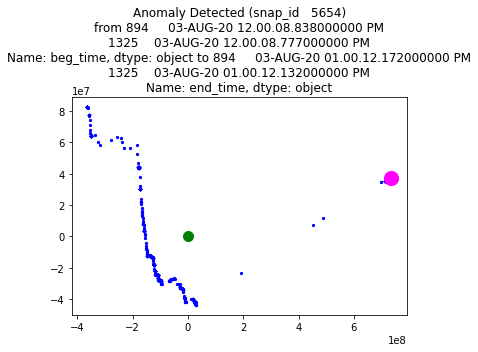


Done checking.



In [22]:
# FOR DEPLOYMENT

# For deployment, build the cluster with ALL available data and
# check if the most recent snap is anomalous.

endidx   = len(sysmetricDFpiv.index)+1

#
# 1. Build The Cluster - from row 0 to row endidx
#
    
workDF = sysmetricDFpiv[0:endidx]
        
beginSnapID = int(workDF.head(1)['SNAP_ID'].values)
endSnapID   = int(workDF.tail(1)['SNAP_ID'].values)

print("Building cluster from/to snap_id {sb:4d}/{se:4d}, {l:4d} snap_ids. Checking...".format(sb=beginSnapID , se=endSnapID, l=endidx))

if doCS:
    workDF = CS_encode(workDF, False)
    
model_init, model_fit, model_fitpred = create_cluster(workDF.drop(columns=['SNAP_ID']), cluster_type, 1, verbose_in=False)
    
#
# 2. Determine Anomaly Distance Threshold
#
    
distancesDF, threshold = get_point_to_centroid(cluster_type, model_init, model_fit, workDF.drop(columns=['SNAP_ID']), 1-1, verbose_in=False)
    
currentDistance  = float(distancesDF.tail(1)['distance'].values)
currentThreshold = float(distancesDF.tail(1)['threshold'].values)
#currentSnapID   = endSnapID
    
#
# 3. Check If Most Recent Snap Is An Anomaly. If so, alert...
#
    
if currentDistance > currentThreshold:
        
    #
    # 4. Anomaly detected... Alert!
    #
        
    b_time, e_time = get_b_e_times(snapDF, endSnapID)
        
    print("* Anomoly detected for snap_id {s:6d}".format(s=endSnapID))
    print("     from {beg} to {end}".format(beg=b_time, end=e_time))
    print("     dist={d:8.3f} > thresh={t:8.3f} loop={loop:8d}".format(d=currentDistance, t=currentThreshold, loop=endidx))
    chart_anom2D(workDF, snapDF, endSnapID, cluster_type, CS_in=doCS)
        
    # Quick! Alert the DBAs!!
        
else:
    print("     Anomoly NOT detected for snap_id {s:6d}  (distance={d:8.3f} <= threshold={t:8.3f})".format(s=endSnapID, d=currentDistance, t=currentThreshold))


print("\nDone checking.\n")

In [18]:
#look in past data
# Simply overwriting above startidx and endidx variables)
startidx = 450    # S1:  5  S2: 500
endidx   = 500   # S1: 50  S2: 800

for rowidx in range(startidx, endidx):
    
    #
    # 1. Build The Cluster - from row 0 to row rowidx. First rowidx will be startidx.
    #
    
    workDF = sysmetricDFpiv[0:rowidx]
        
    beginSnapID = int(workDF.head(1)['SNAP_ID'].values)
    endSnapID   = int(workDF.tail(1)['SNAP_ID'].values)

    print("Building cluster from/to snap_id {sb:4d}/{se:4d} loop {l:4d} Checking...".format(sb=beginSnapID , se=endSnapID, l=rowidx))

    if doCS:
        workDF = CS_encode(workDF, False)
    
    model_init, model_fit, model_fitpred = create_cluster(workDF.drop(columns=['SNAP_ID']), cluster_type, 1, verbose_in=False)
    
    #
    # 2. Determine Anomaly Distance Threshold
    #
    
    distancesDF, threshold = get_point_to_centroid(cluster_type, model_init, model_fit, workDF.drop(columns=['SNAP_ID']), 1-1, verbose_in=False)
    
    currentDistance  = float(distancesDF.tail(1)['distance'].values)
    currentThreshold = float(distancesDF.tail(1)['threshold'].values)
    #currentSnapID   = endSnapID
    
    #
    # 3. Check If Most Recent Snap Is An Anomaly. If so, alert...
    #
    
    if currentDistance > currentThreshold:
        
        #
        # 4. Anomaly detected... Alert!
        #
        
        b_time, e_time = get_b_e_times(snapDF, endSnapID)
        
        print("* Anomoly detected for snap_id {s:6d}".format(s=endSnapID))
        print("     from {beg} to {end}".format(beg=b_time, end=e_time))
        print("     dist={d:8.3f} > thresh={t:8.3f} loop={loop:8d}".format(d=currentDistance, t=currentThreshold, loop=rowidx))
        chart_anom2D(workDF, snapDF, endSnapID, cluster_type, CS_in=doCS)
        
        # Quick! Alert the DBAs!!
        
    else:
        print("     Anomoly NOT detected for snap_id {s:6d}  (distance={d:8.3f} <= threshold={t:8.3f})".format(s=endSnapID, d=currentDistance, t=currentThreshold))


print("\nDone checking.\n")


Building cluster from/to snap_id 4937/5386 loop  450 Checking...
     Anomoly NOT detected for snap_id   5386  (distance=162082075.002 <= threshold=212667591.473)
Building cluster from/to snap_id 4937/5387 loop  451 Checking...
     Anomoly NOT detected for snap_id   5387  (distance=163205814.645 <= threshold=213028641.882)
Building cluster from/to snap_id 4937/5388 loop  452 Checking...
     Anomoly NOT detected for snap_id   5388  (distance=163561117.688 <= threshold=213389708.461)
Building cluster from/to snap_id 4937/5389 loop  453 Checking...
     Anomoly NOT detected for snap_id   5389  (distance=163362337.664 <= threshold=213749543.128)
Building cluster from/to snap_id 4937/5390 loop  454 Checking...
     Anomoly NOT detected for snap_id   5390  (distance=163133863.215 <= threshold=214108088.135)
Building cluster from/to snap_id 4937/5391 loop  455 Checking...
     Anomoly NOT detected for snap_id   5391  (distance=163824113.223 <= threshold=214467311.916)
Building cluster from/

In [18]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y %H:%M:%S")
print("Done with entire notebook at", dt_string)

Done with entire notebook at 30-Nov-2020 15:09:28
